# Import

In [1]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Load non-airpuff calcium traces

In [ ]:
"""
This script includes:
    -Decoding analysis on reward/punishment after & before response (for each session & across sessions)
    -Decoding analysis on stimulus left/right at stimulus onset (for each session & across sessions)
    -Decoding analysis on licking left/right before response (for each session & across sessions)

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

In [2]:
animal_folder_name = "/Users/felicia/Documents/CFIN/233/233_traces/"

#session_list = ['04','06','07','08','10','11','12','13'] # 232
session_list = ['06','07','08','09','10','11','12','13'] # 233

In [3]:
session = "06"

In [4]:
# load csv calcium traces
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape
# display the top of the table
#df.head()

# EXTRACT THE DATA YOU WILL NEED FOR THE ANALYSIS
# as you can see from the head, first row is useless, the first column is time, all the other columns are channels
# calcium data are sampled at 100 msec. 
# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]
#plt.plot(np.arange(len(time_array)-1), time_sampling, '.')
#plt.show()

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

#create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()

# Check traces data

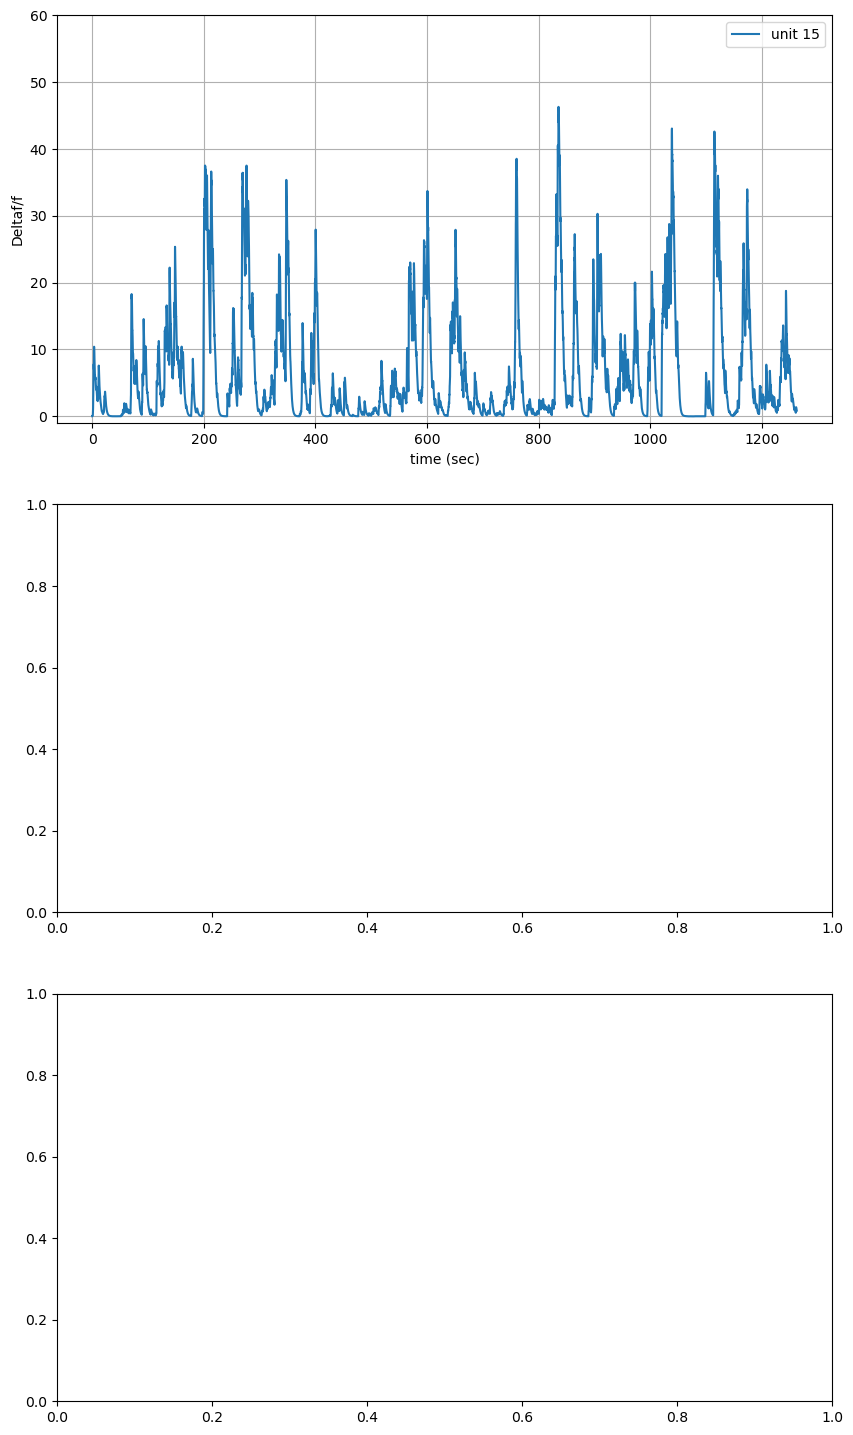

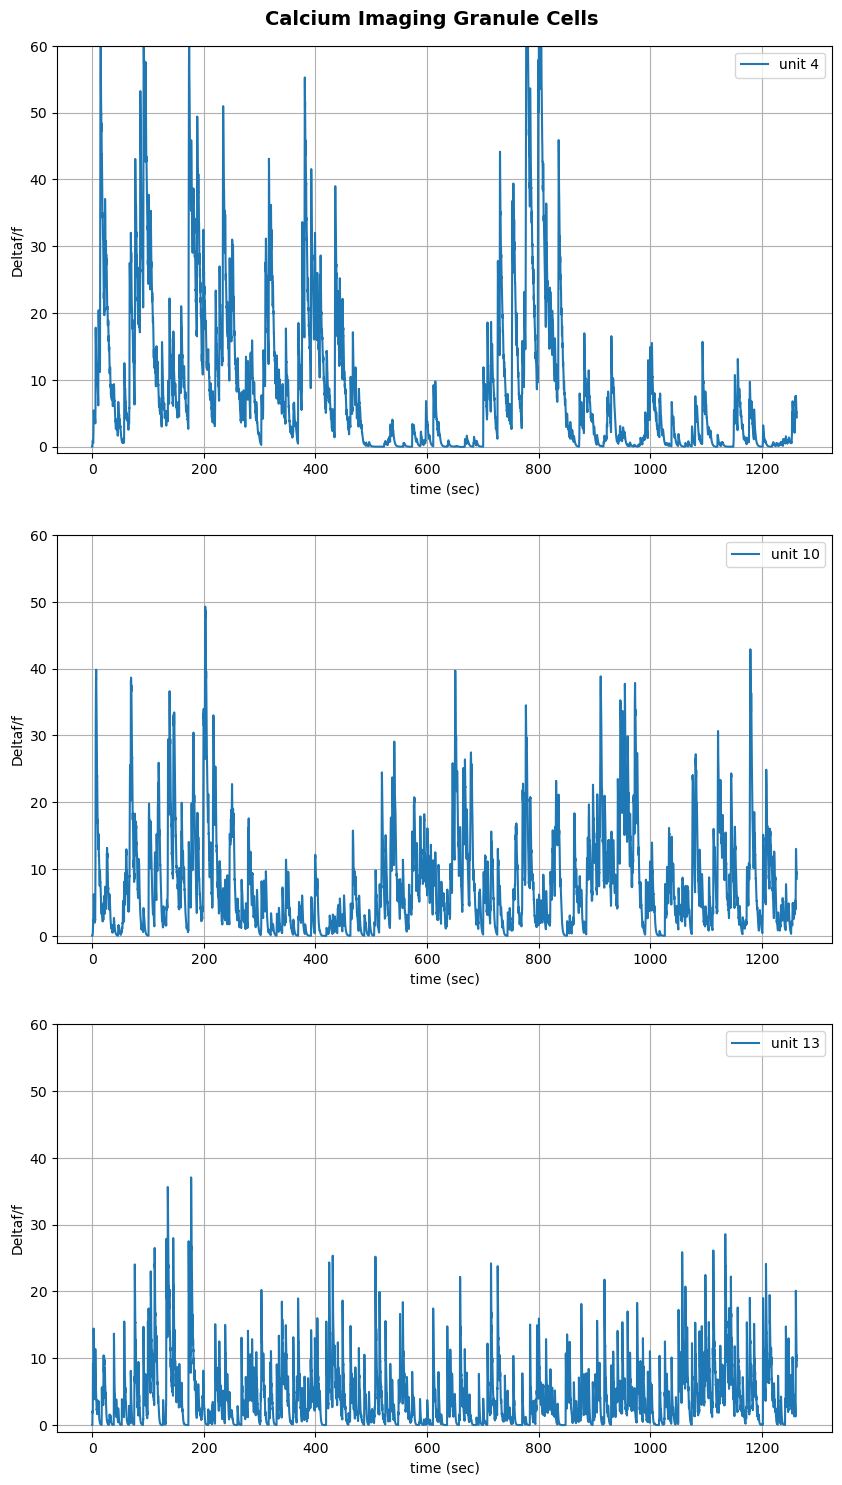

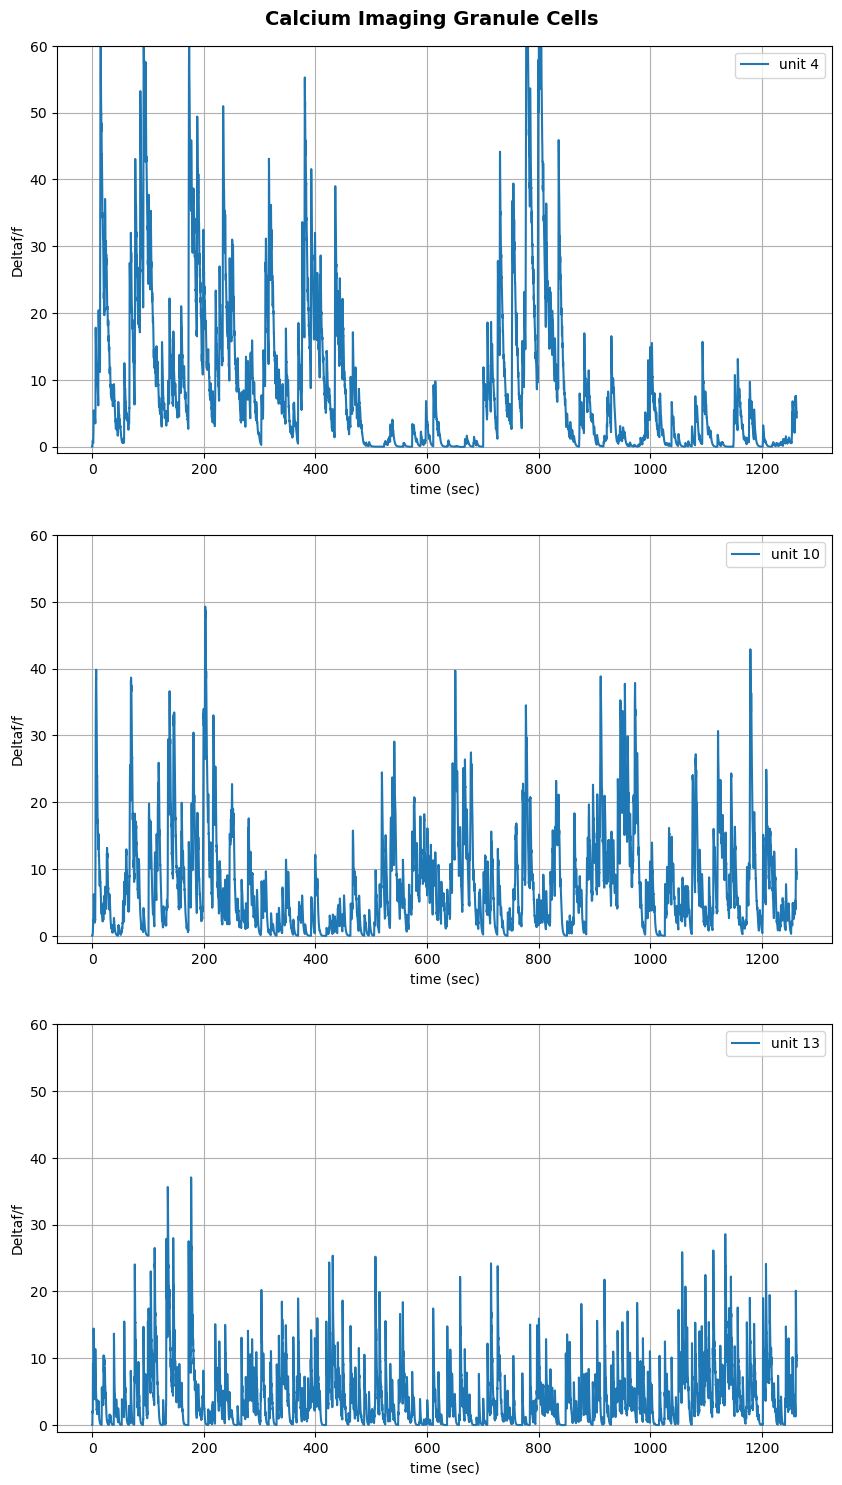

In [7]:
# check your data - plot some channels
units = [4,10,13]
fig, axs = plt.subplots(len(units),1, figsize=(10,18))

for u in range(len(units)):
    axs[u].plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
    axs[u].set_xlabel('time (sec)')
    axs[u].set_ylabel('Deltaf/f')
    #axs[u].set_ylim([-0.001,0.01])
    axs[u].set_ylim([-1,60])
    axs[u].grid()
    axs[u].legend()
    
fig.suptitle('Calcium Imaging Granule Cells', y=0.9, fontsize=14, fontweight='bold')
plt.show()

# Load behavioural data

In [8]:
# load the behavioral data
#folder_name = "trial_info"
#bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
#trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

# extract information from trial_info: in matlab this is a struct with the fields:
#trials_start_time = trial_info['trial_info'][0,0][0].ravel()
#trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
#trials_response = trial_info['trial_info'][0,0][2].ravel()
#trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
#trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
#trials_end_time = trial_info['trial_info'][0,0][5].ravel()
#n_trials = len(trials_end_time)

# load behavioural data (.pkl file)
input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     trial_info = pickle.load(fp)

# extract information for trial_info: in PYTHON
trials_start_time = np.array(trial_info['start_time'])
trials_stimulus_on = np.array(trial_info['stimulus_on'])
trials_response = np.array(trial_info['response'])
trials_is_right_lick = np.array(trial_info['is_right_lick'])
trials_is_reward = np.array(trial_info['is_reward'])
trials_end_time = np.array(trial_info['end_trial'])
n_trials = len(trials_end_time)

# 500msec between start and stimulus onset
new_start = [] # initiate empty list
new_end = [] # initiate empty list
new_start.append(trials_stimulus_on[0]-0.5) # append first start
new_end.append(trials_stimulus_on[1]-0.5) # append first end
for i in range(1,n_trials-1): # append start & end times for each trial (except last)
    new_start.append(trials_stimulus_on[i]-0.5)
    new_end.append(trials_stimulus_on[i+1]-0.5)
new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
new_end.append(trials_end_time[n_trials-1]) # append last end
new_start = np.array(new_start) # turn list to array
new_end = np.array(new_end)
n_trials = len(new_end)

# alternatively, check where the stimulus was and try to decode that from the trials aligned at stimulus onset
# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

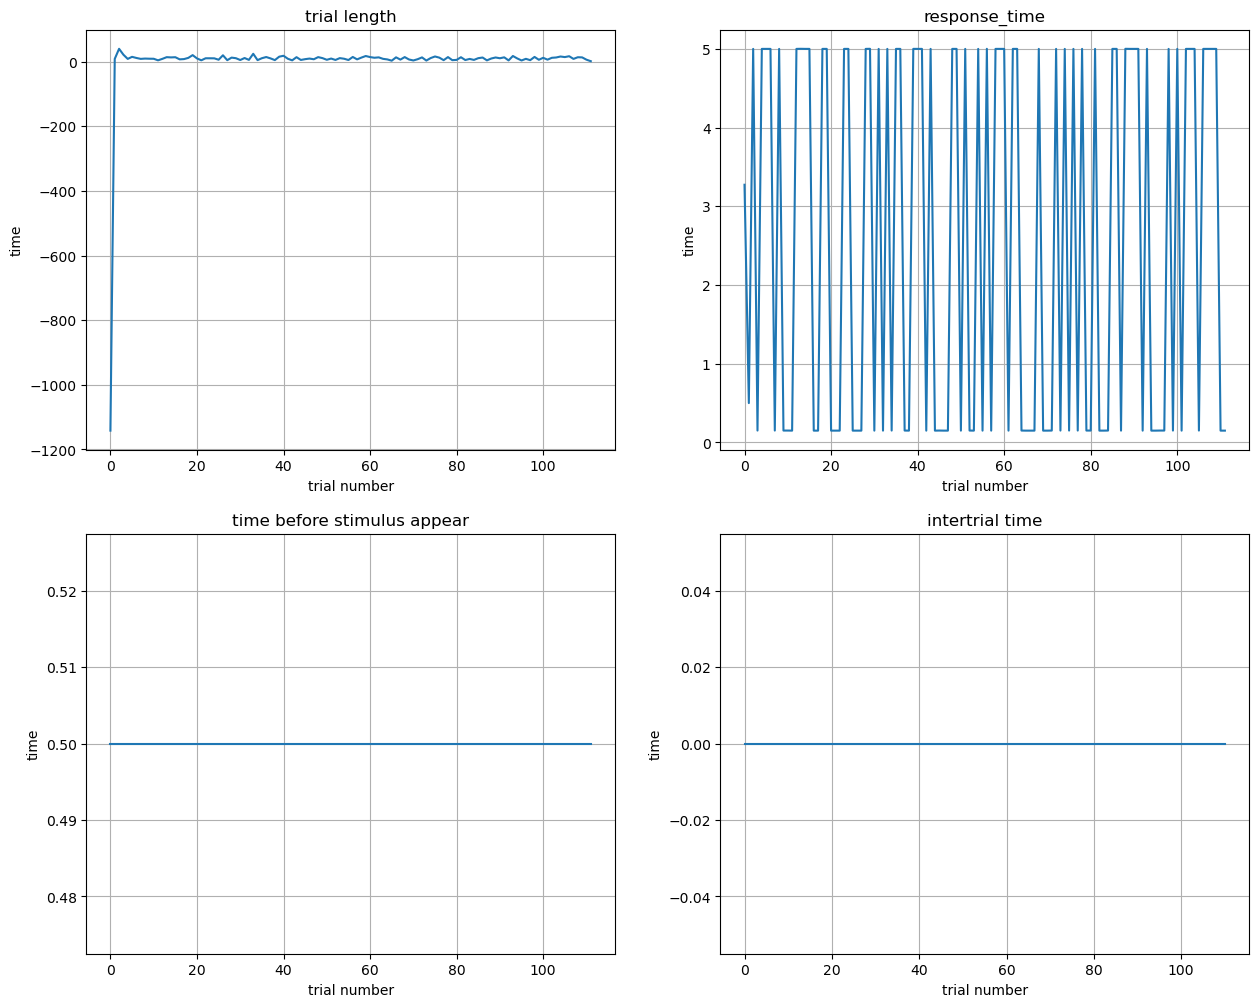

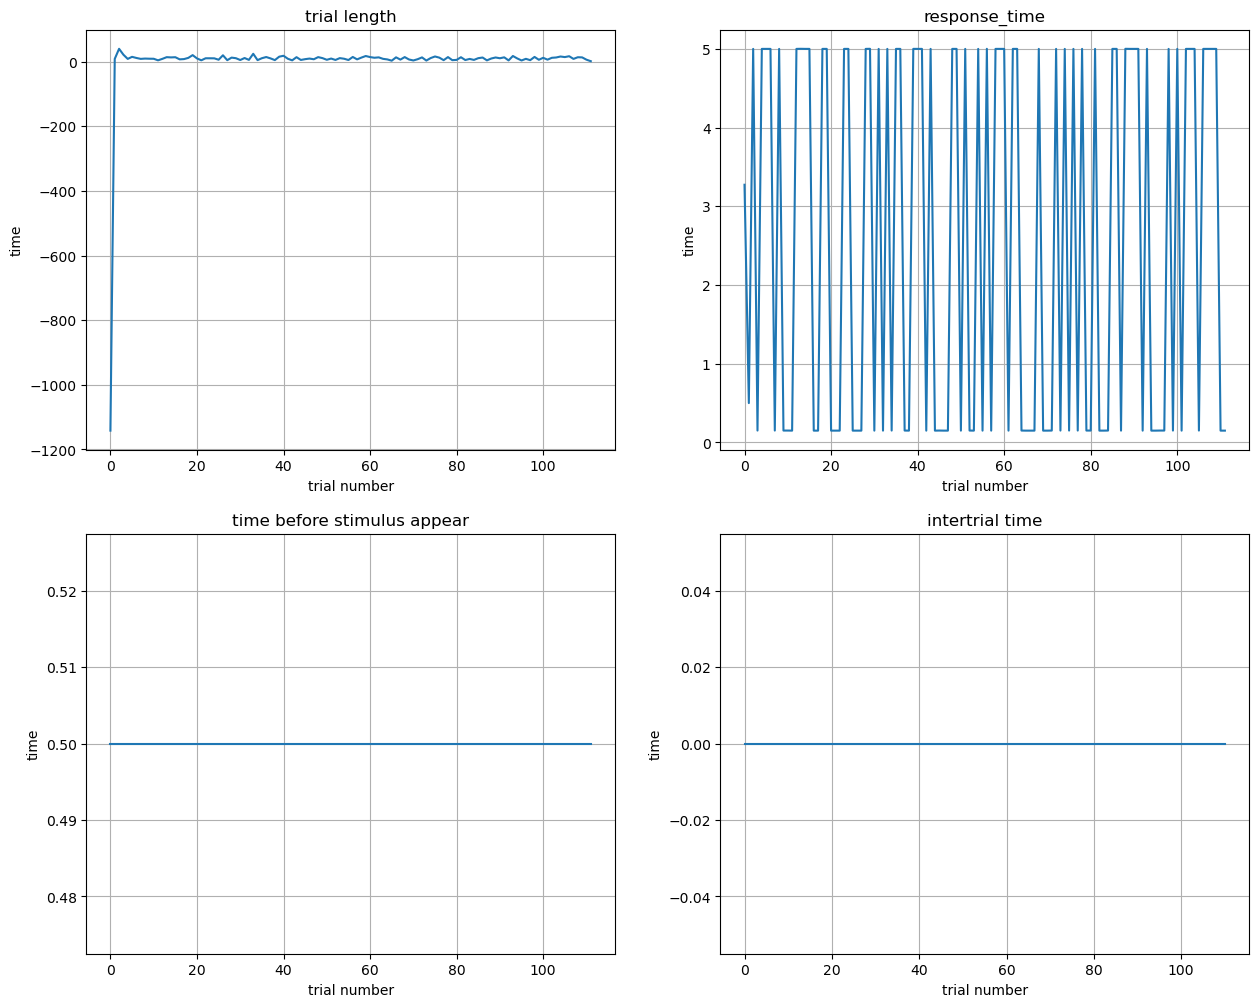

In [10]:
# trial length, response time, time before stimulus appears and intertrial time
fig, axs = plt.subplots(2,2,figsize=(15,12))
trials_length = new_end - new_start
response_time = trials_response - trials_stimulus_on
stim_time = trials_stimulus_on - new_start
intertrial_time = []
for i in range(1,n_trials):
    intertrial_time.append(new_start[i] - new_end[i-1])

# plot variables in subplots
axs[0, 0].plot(np.arange(n_trials), trials_length)
axs[0, 0].set_title('trial length')
axs[0, 1].plot(np.arange(n_trials), response_time)
axs[0, 1].set_title('response_time')
axs[1, 0].plot(np.arange(n_trials), stim_time)
axs[1, 0].set_title('time before stimulus appear')
axs[1, 1].plot(np.arange(n_trials-1), intertrial_time)
axs[1, 1].set_title('intertrial time')

# label axes
for ax in axs.flat:
    ax.set(xlabel='trial number', ylabel='time')
    ax.grid()
    
plt.show()

In [11]:
print("number of trials:",n_trials)
print("number of neurons:",n_channels)
print("ratio trials/neurons:", n_trials/n_channels)
print("performance:",np.sum(trials_is_reward),"/",n_trials,"=",(np.sum(trials_is_reward))/n_trials*100, "%")
print("average trial length (sec):",np.mean(trials_length) * sampling_rate) # in sec

number of trials: 112
number of neurons: 16
ratio trials/neurons: 7.0
performance: 56 / 112 = 50.0 %
average trial length (sec): -0.015717857142857183


In [12]:
# split traces data into trials
X = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

# Normalisation

In [13]:
# normalize calcium data, bringing the firing of single units on the same scale. 
z_units = scipy.stats.zscore(channels_array)

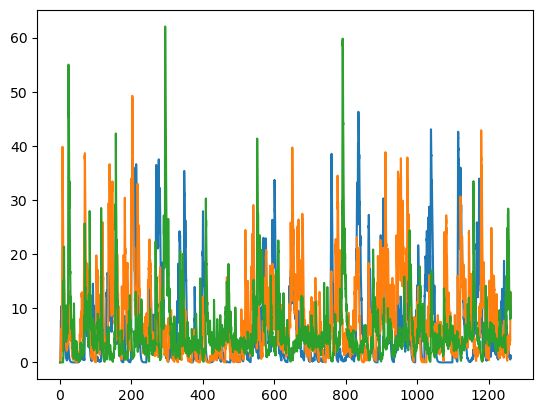

In [15]:
# check your data - plot some neurons
units = [10,12]

for u in range(len(units)):
    plt.plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
plt.show()

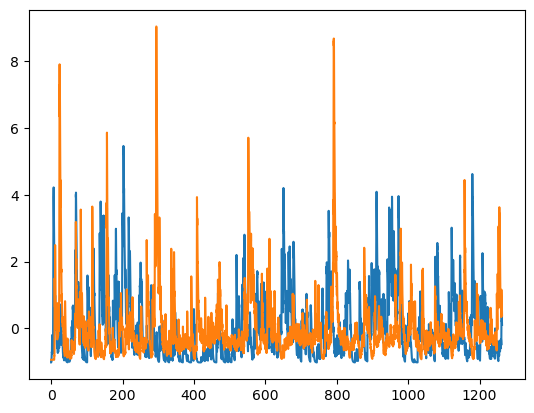

In [16]:
# compare with the normalized units
units = [10,12]

for u in range(len(units)):
    plt.plot(time_array,z_units[:,units[u]], label='unit %d'%units[u])
plt.show()

In [17]:
# split traces data into trials
X_norm = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X_norm[i] = z_units[lower_bound:upper_bound,:]

# Analysis on reward and punishment (aligned at response) ALL UNITS

In [18]:
# create the data array you will need to use as X with shape [n_trials, n_channels, n_timepoints]
# depending on what you want to test you will need to create different X

# trials have different length. Here Align them at the response, 
# and take the amount of points available in all trials around the response 

# set threshold for minimum time points before response
thr = 0.5 #0.5
n_before_resp = 5 #5
n_after_resp = 40
n_timepoints = n_before_resp+ n_after_resp

selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
n_trials = np.sum(selected_trials)

X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
        if X_norm[i].shape[0]-resp_timepoint>n_after_resp:
            X_response[j,:,:] = x
            j +=1

# transpose to have X in shape [n_trials, n_channels, n_timepoints]
X_response = X_response.transpose(0,2,1)

In [19]:
# analysis on reward and punishment, aligned at response
decode_str = 'reward_or_punish'
b = trials_is_reward[0:-1]
y = b[selected_trials==1]

# ANALYSIS ALL 
print("all units decoding - response aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=3
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    # if we want to decode from a group of units only
    # units_selection = [15, 22]
    # xt = X_response[:,units_selection,t]
    
    # if we want to decode from all the units
    xt = X_response[:,:,t]
    

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1
                

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5045045045045045


In [20]:
# save pickle file
#output_filename = "/Users/felicia/Documents/CFIN/232/232_traces/pickle/response_calcium_reward_2021-05-{0}.pkl".format(session)
#with open(output_filename, 'wb') as fp:
#    pickle.dump((X_response, y), fp, protocol=pickle.HIGHEST_PROTOCOL)

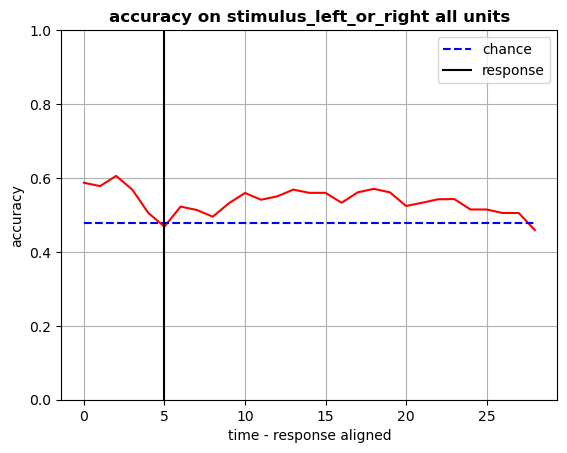

In [27]:
# plot reward or punishment at response
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis stimulus (aligned at stimulus onset) ALL UNITS

In [28]:
# create other X, this time 
# align at stimulus onset and decode where the stimulus was
# select the amount of points available in all trials around the stimulus

stim_to_end_min = 24 #int(np.min(new_end - trials_stimulus_on) / sampling_rate)
start_to_stim_min = 5 #int(np.min(trials_stimulus_on - new_start) / sampling_rate)

selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) * 10 > 25
n_trials = np.sum(selected_trials)

n_timepoints = start_to_stim_min + stim_to_end_min
#n_trials = len(new_end)
X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_channels))

j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
        X_stimulus[j,:,:] = X_norm[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
        j +=1
    
#transpose to have them in the right shape
X_stimulus = X_stimulus.transpose(0,2,1)

In [29]:
# analysis stimulus left or right with data aligned at stimulus onset
decode_str = 'stimulus_left_or_right'
y = stimulus_reconstruction[np.where(selected_trials)]

# ANALYSIS ALL 
print("all units decoding - stimulus aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=5
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    # if we want only some units
    # ideally a meaningful subset of units - i.e. those highly correlated at stimulus onset
    # units_selection = [2,32]
    # xt = X_response[:,units_selection,t]
    
    # if we want to decode from all of the units
    xt = X_stimulus[:,:,t]

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1
                

all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.47706422018348627


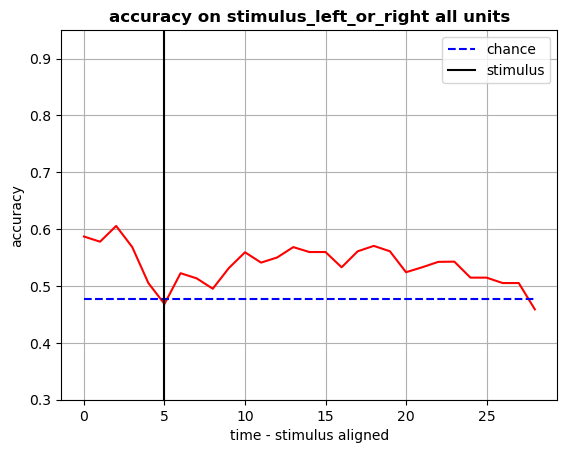

In [30]:
# plot stimulus decoding
fig = plt.figure()

plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=start_to_stim_min, color='k', label="stimulus")
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis on reward and punishment across all sessions (aligned at response)

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5045045045045045
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5111111111111111
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5121951219512195
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5625
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4824561403508772
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4895833333333333
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4142857142857143
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5263157894736842


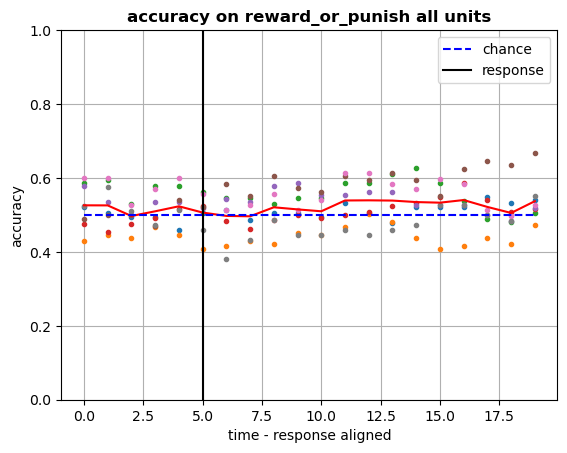

In [31]:
# set threshold for minimum time points before response
thr = 0.5
n_before_resp = 5
n_after_resp = 15
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each non-airpuff session:
for session in session_list: 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    n_timepoints = n_before_resp+ n_after_resp

    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X_norm[i].shape[0]-resp_timepoint>n_after_resp:
                X_response[j,:,:] = x
                j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [32]:
# saving as pickle file
output_filename = "assemblies_activity/response_noairpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis stimulus across sessions (aligned at stimulus onset)

all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5045045045045045
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5111111111111111
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5121951219512195
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5396825396825397
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.49557522123893805
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.4583333333333333
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.4714285714285714
all units decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.48


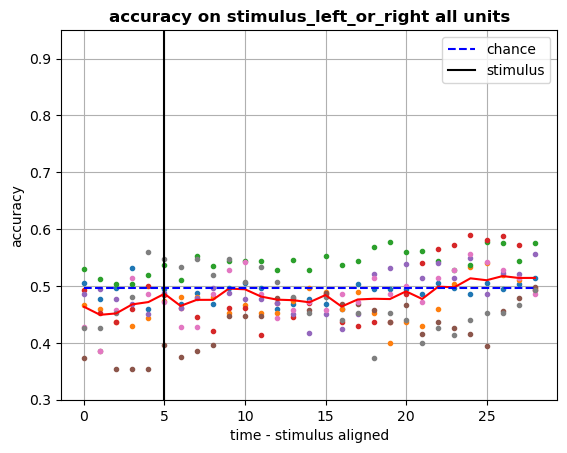

In [33]:
# set threshold for minimum time points before response
stim_to_end_min = 24
start_to_stim_min = 5

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each non-airpuff session:
for session in session_list: 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) * 10 > 25
    n_trials = np.sum(selected_trials)

    n_timepoints = start_to_stim_min + stim_to_end_min
    X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_channels))

    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
            X_stimulus[j,:,:] = X_norm[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
            j +=1

    #transpose to have them in the right shape
    X_stimulus = X_stimulus.transpose(0,2,1)
    
    
    # analysis stimulus left or right with data aligned at stimulus onset
    decode_str = 'stimulus_left_or_right'
    y = stimulus_reconstruction[np.where(selected_trials)]

    # ANALYSIS ALL 
    print("all units decoding - stimulus aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=5
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        xt = X_stimulus[:,:,t]

        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))


    
# plot stimulus decoding
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=start_to_stim_min, color='k', label="stimulus")
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()
    

In [34]:
# saving as pickle file
output_filename = "assemblies_activity/stimulus_noairpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis on reward and punishment across all sessions (before response)

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5245901639344263
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5047619047619047
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5405405405405406
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.45871559633027525
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5056179775280899
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4264705882352941
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5142857142857142


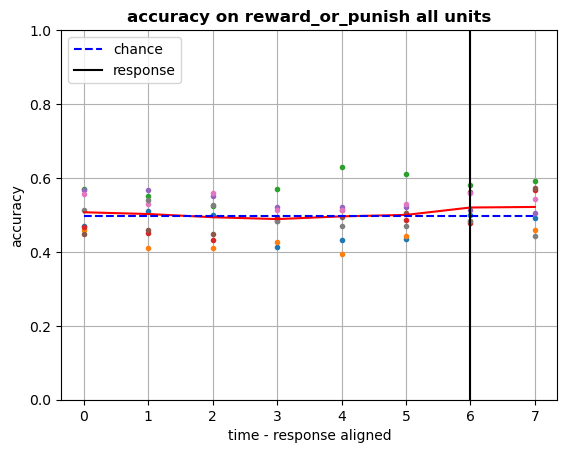

In [35]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each non-airpuff session:
for session in session_list: 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    n_timepoints = n_before_resp+ n_after_resp

    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X_norm[i].shape[0]-resp_timepoint>n_after_resp:
                X_response[j,:,:] = x
                j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [36]:
# saving as pickle file
output_filename = "assemblies_activity/before_response_noairpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis lick left or right across all sessions (before response)

all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
1.0
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
1.0
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
1.0
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.8018018018018018
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.9357798165137615
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.9438202247191011
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.14705882352941177
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.11428571428571428


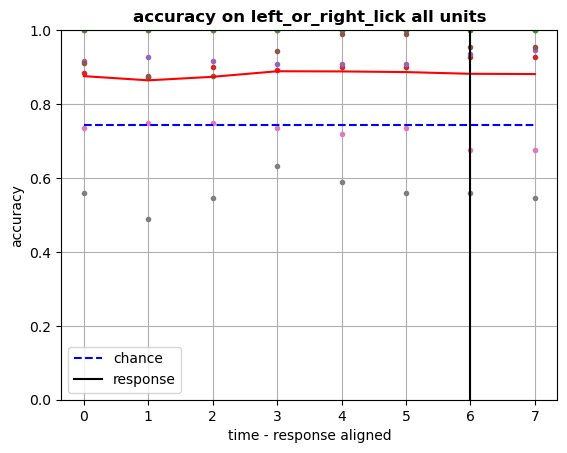

In [37]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each non-airpuff session:
for session in session_list: 

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # normalize calcium data, bringing the firing of single units on the same scale. 
    z_units = scipy.stats.zscore(channels_array)
    # split traces data by trials
    X_norm = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X_norm[i] = z_units[lower_bound:upper_bound,:]
        
    #### DECODING ####
    n_timepoints = n_before_resp+ n_after_resp

    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
    n_trials = np.sum(selected_trials)

    X_response = np.zeros(shape=(n_trials, n_timepoints , n_channels ))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X_norm[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X_norm[i].shape[0]-resp_timepoint>n_after_resp:
                X_response[j,:,:] = x
                j +=1

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    # analysis lick left or right, aligned at response
    decode_str = 'left_or_right_lick'
    b = trials_is_right_lick[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # if we want to decode from a group of units only
        # units_selection = np.arange(25,34)
        # xt = X_response[:,units_selection,t]

        # if we want to decode from all the units
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
            
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.') #,color='r')

plt.plot(x, y1,'r')
plt.plot(x, y2, '--b', label="chance")

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s all units"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [38]:
# saving as pickle file
output_filename = "assemblies_activity/lick_noairpuff_activity.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(y1, fp, protocol=pickle.HIGHEST_PROTOCOL)